In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch

sys.path.append('../')

from src_experiment import NeuralNet, moon_path, wbc_path, get_moons_data, get_wbc_data
from geobin import RegionTree, TreeNode

In [2]:
# test params
experiment = "wbc"
arch = "decreasing"
dropout = 0.0
noise = 0.0
run_number = 0
path_fn = moon_path if experiment == "moon" else wbc_path
data_fn = get_moons_data if experiment == "moon" else get_wbc_data

In [3]:
# Load the state dicts
epochs = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,74]
state_dicts = {epoch: path_fn(arch, dropout, noise, run_number) /"state_dicts"/f"epoch{epoch}.pth" for epoch in epochs}

In [13]:
# Get the testing data
_, data = data_fn(noise, batch_size=32)
len(data)

4

In [15]:
ncounts_per_epoch = {}
start = time.time()
for epoch in epochs:
    state_dict = torch.load(state_dicts[epoch])
    tree = RegionTree(state_dict)
    tree.build_tree(verbose=False, check_feasibility=False)
    tree.pass_dataloader_through_tree(data)
    tree.collect_number_counts()
    ncounts_per_epoch[epoch] = tree.get_number_counts()
    # print(tree.size)
end = time.time()
print(f"Total time taken old: {end-start:.3f} s")


ncounts_per_epoch_checked = {}
start = time.time()
for epoch in epochs:
    state_dict = torch.load(state_dicts[epoch])
    tree = RegionTree(state_dict)
    tree.build_tree(verbose=False, check_feasibility=True)
    tree.pass_dataloader_through_tree(data)
    tree.collect_number_counts()
    ncounts_per_epoch_checked[epoch] = tree.get_number_counts()
    # print(tree.size)
end = time.time()
print(f"Time taken (checking): {end-start:.3f} s")


Total time taken old: 4.207 s
Time taken (checking): 30.691 s


## Region analysis

In [6]:
layers = ncounts_per_epoch[0]["layer_idx"].unique()
nr_regions_pr_layer = {layer: [] for layer in layers}
for epoch, frame in ncounts_per_epoch_checked.items():
    for layer in frame["layer_idx"].unique():
        nr_regions = len(frame[frame["layer_idx"]==layer])
        nr_regions_pr_layer[layer].append(nr_regions)
nr_regions_pr_layer

{np.int64(1): [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
 np.int64(2): [148,
  150,
  148,
  148,
  148,
  148,
  148,
  148,
  148,
  148,
  148,
  162,
  162,
  162,
  162,
  162],
 np.int64(3): [312,
  324,
  324,
  324,
  324,
  324,
  332,
  332,
  332,
  332,
  344,
  358,
  358,
  358,
  358,
  358],
 np.int64(4): [432,
  436,
  452,
  452,
  452,
  452,
  460,
  460,
  460,
  460,
  472,
  486,
  486,
  486,
  486,
  486]}

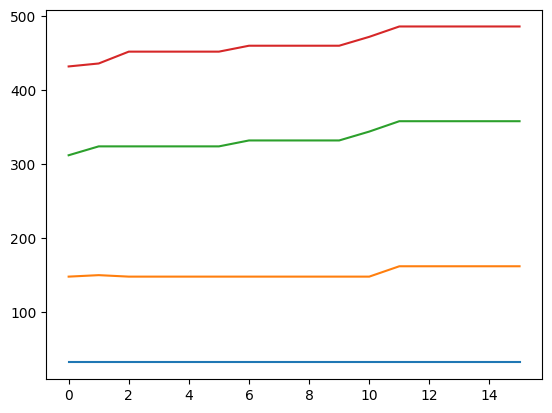

In [7]:
for layer, regions in nr_regions_pr_layer.items():
    plt.plot(regions, label=f"Layer {layer}")
plt.show()

## Estimates

In [8]:
from src_experiment import DivergenceEngine, QUANTITIES_TO_ESTIMATE
from typing import Dict, List
class EstimateQuantities1Run:
    """
    Experiment-specific wrapper that:
    - loads number counts
    - loops over epochs
    - delegates all math to DivergenceEngine
    """

    def __init__(
        self,
        ncounts
    ):
        self.ncounts = ncounts

        self.estimates: Dict[str, List[pd.DataFrame]] = {
            q: [] for q in QUANTITIES_TO_ESTIMATE
        }

        # Perform calculations
        self.calculate_estimates()

    # ------------------------------------------------------------------

    def calculate_estimates(self) -> None:
        for epoch, frame in self.ncounts.items():
            engine = DivergenceEngine(frame)
            epoch_results = engine.compute()

            for key, df in epoch_results.items():
                df.insert(0, "epoch", epoch)
                self.estimates[key].append(df)

        # Concatenate epochs
        for key, frames in self.estimates.items():
            self.estimates[key] = (
                pd.concat(frames, ignore_index=True)
                .rename_axis(None, axis=1)
            )

    def get_estimates(self) -> Dict[str, pd.DataFrame]:
        return self.estimates


In [9]:
est1 = EstimateQuantities1Run(ncounts_per_epoch)
est2 = EstimateQuantities1Run(ncounts_per_epoch_checked)


/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:117: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / self.m_w
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m

In [10]:
n1 = est1.get_estimates()
n2 = est2.get_estimates()
for Q in QUANTITIES_TO_ESTIMATE:
    assert np.all(np.abs(n1[Q] - n2[Q]) < 1e-6)

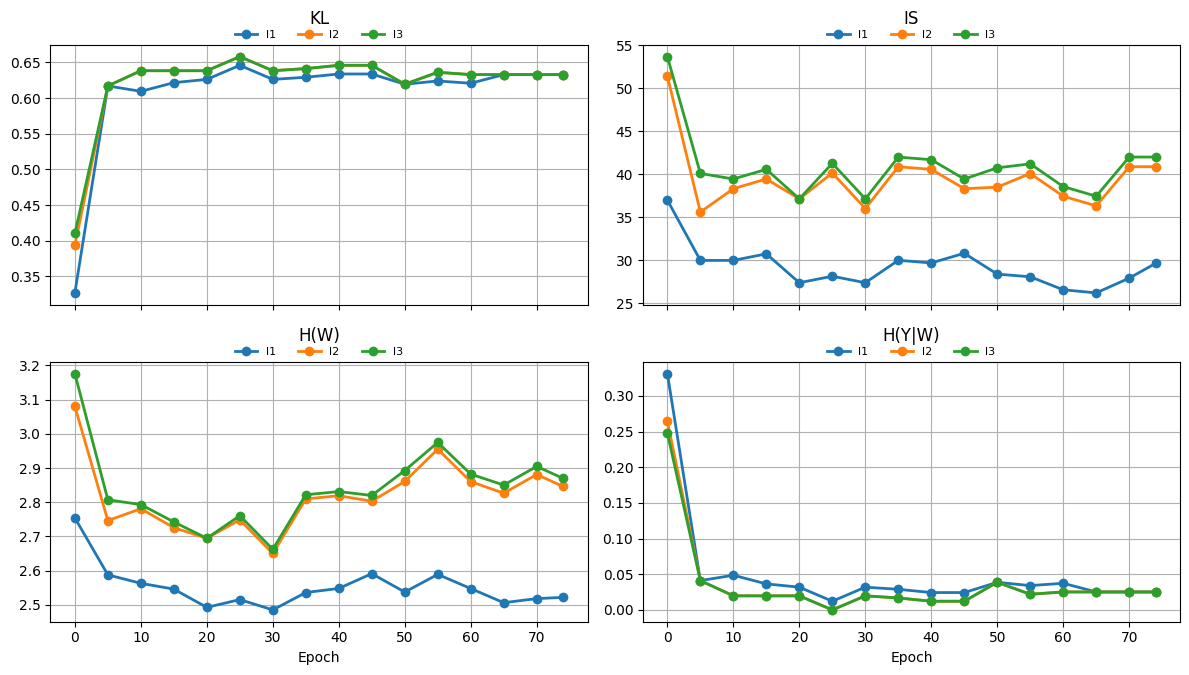

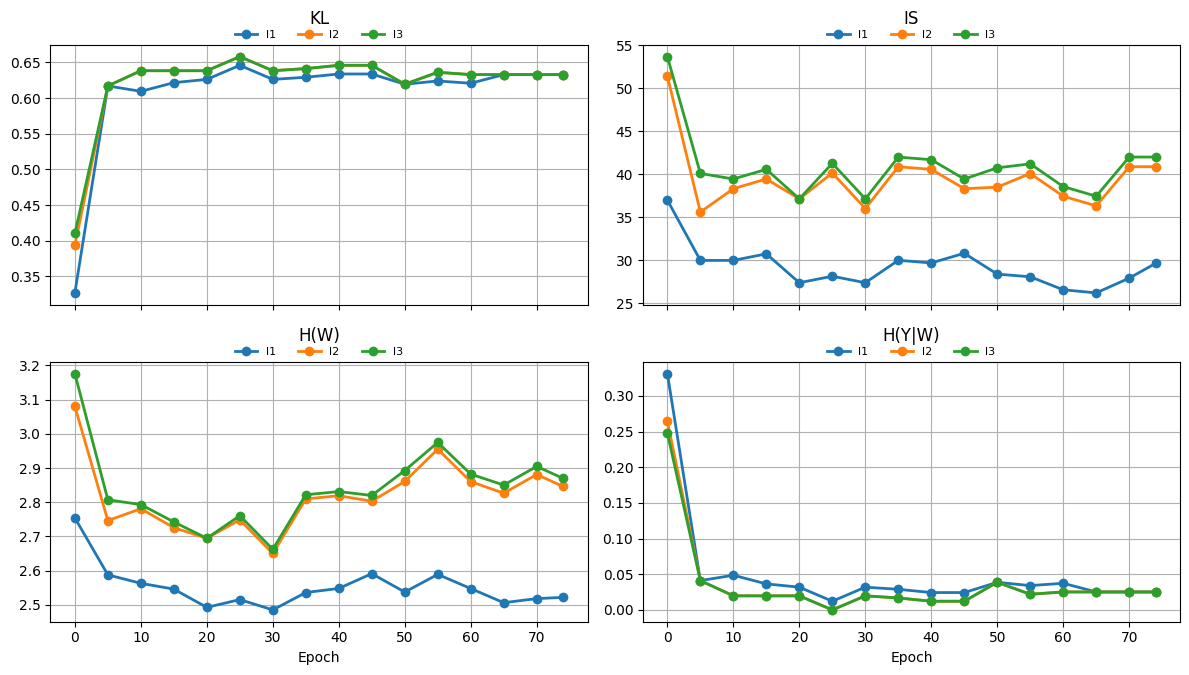

In [11]:
from visualization import plot_all_quantities
plot_all_quantities(est1.get_estimates())
plot_all_quantities(est2.get_estimates())